# Fraudulent Credit Card Transactions Detection Models 

In this project some machine learning models are trained for classifying some credit card transactions into two classes: fraud or not fraud. The dataset that is considered contains 1 million examples, but for computational needs only the first 10000 examples are used. Here you can find the complete dataset: https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud. 

The project is organized as follows: <br>

1. First of all a very simple EDA of the dataset is provided. <br>
2. After that some machine learning models are trained to predict if a transaction is fraudulent or not. Before that, a cross validation procedure is provided, thanks to RandomizedSearchCV, in order to tune the hyperparameters of all the considered models. These models are: <br>
* `K-Nearest Neighbors Classifier(KNN)` <br>
* `Decision Tree Classifier (DT)` <br>
* `Support Vector Classifier (SVC)` <br>
* `Random Forest Classifier(RF)`<br><br> 
3. In conclusion, the models are tested on the test set and the best model is choosen. 

Here it is a prospectus of the variables into the dataset:

|   VARIABLE NAME 	|   VARIABLE DESCRIPTION	|   VARIABLE TYPE	| VALUES  	|
|---	|---	|---	|---	|
|  distance_from_home 	|   the distance from home where the transaction happened.	|   continuous numerical	|   	|
|   distance_from_last_transaction	|   the distance from last transaction happened	|   continuous numerical	|   	|
|   ratio_to_median_purchase_price	|   Ratio of purchased price transaction to median purchase price	|  continuous numerical 	|   	|
|   repeat_retailer		|  Is the transaction happened from same retailer 	|  binary	|  1: yes <br> 0: no|
|   used_chip		|   Is the transaction through chip (credit card)	|   binary	|   1: yes <br> 0: no|
|   used_pin_number	|    Is the transaction happened by using PIN number	|   binary	| 1: yes <br> 0: no  	|
|   online_order		|   Is the transaction an online order	|   binary	|   1: yes <br> 0: no	|
|  fraud 	|   Is the transaction fraudulent	|   binary	|   1: yes <br> 0: no	|

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

# ML standard libraries
from sklearn.preprocessing import MinMaxScaler as scaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as CF
from sklearn.model_selection import RandomizedSearchCV as RSCV 

# Models 
from sklearn.neighbors import KNeighborsClassifier as KNN 
from sklearn.tree import DecisionTreeClassifier as DT 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier as RF 

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# I load the dataset
df=pd.read_csv('card_transdata_reduced.csv')
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
9995,4.225100,2.678220,0.556858,1.0,0.0,0.0,1.0,0.0
9996,3.614858,0.431593,0.061778,1.0,0.0,0.0,1.0,0.0
9997,10.131863,10.262508,2.818090,1.0,0.0,0.0,1.0,0.0
9998,16.306236,0.014054,1.904495,1.0,0.0,0.0,1.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              10000 non-null  float64
 1   distance_from_last_transaction  10000 non-null  float64
 2   ratio_to_median_purchase_price  10000 non-null  float64
 3   repeat_retailer                 10000 non-null  float64
 4   used_chip                       10000 non-null  float64
 5   used_pin_number                 10000 non-null  float64
 6   online_order                    10000 non-null  float64
 7   fraud                           10000 non-null  float64
dtypes: float64(8)
memory usage: 703.1 KB


# EDA

First of all since all the variables, even the binary ones, are encoded as numerical I compute the correlation matrix between all of them:

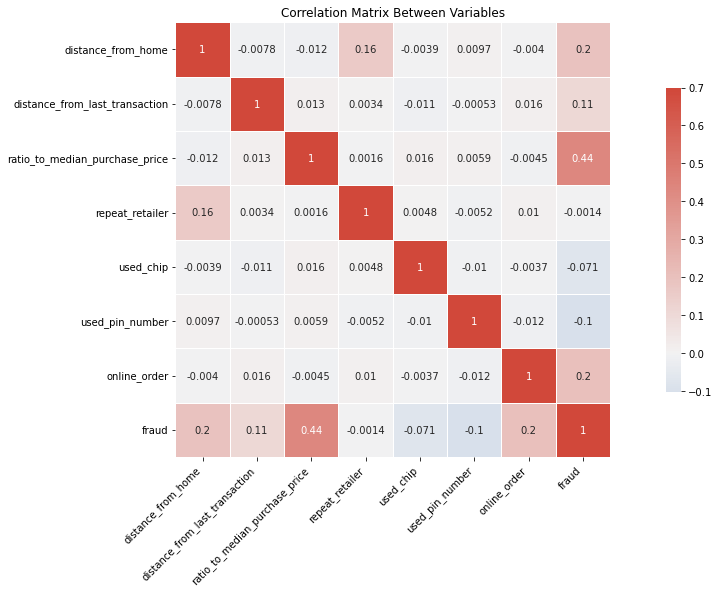

In [4]:
plt.figure(figsize=(20,8))
cmap = sns.diverging_palette(250, 15, as_cmap=True)
sns.heatmap(df.corr(),
            annot=True, vmax=.7, center=0, cmap=cmap,
            square=True, linewidths=.7, cbar_kws={"shrink": .7})

plt.title('Correlation Matrix Between Variables')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

### As we can see from the correlation matrix there are no strong linear correlations between the variables. However the label, i.e. the 'fraud' variable, has a slight positive linear correlation with the variables 'distance_from_home', 'distance_from_last_transaction' and  'online_order', and a bigger one with the variable 'ratio_to_median_purchase_price'. Therefore, we might expect that these variables are the most important ones into the classification of a fraudulent transaction. 

Let us now rename some columns values in order to make the plot visualization cleaner:

In [5]:
# I rename some columns values in order to make the plot visualization cleaner 
D= {'repeat_retailer':{0.0: 'no', 1.0:'yes'}, 'used_chip':{0.0: 'no', 1.0:'yes'},
       'used_pin_number':{0.0: 'no', 1.0:'yes'}, 'online_order':{0.0: 'no', 1.0:'yes'}, 
    'fraud':{0.0: 'no', 1.0:'yes'}}

for column in list(D.keys()):
    df[column] = df[column].map(D[column])

Let us now see a pie plot for the label, i.e. the 'fraud' variable:

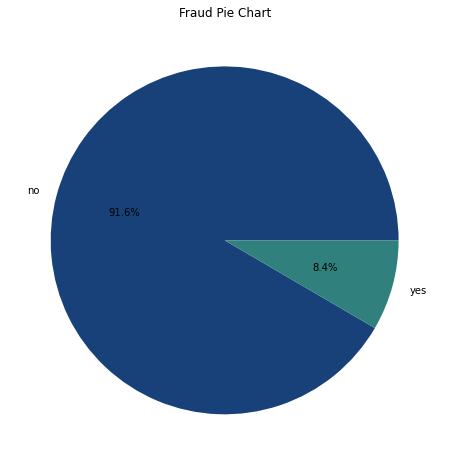

In [6]:
plt.figure(figsize=(14,8))
plt.pie(df['fraud'].value_counts(),
       labels=df['fraud'].value_counts().index, 
       autopct='%.1f%%', 
       colors=sns.color_palette('gist_earth'))
plt.title('Fraud Pie Chart')
plt.show()

### Thus, the vast majority of the transactions are not fraudulent. Consequentially, for evaluating the performance of a model the accuracy is not a good metric, because we have a strong imbalance between the two classes. Hence, we are going to consider the sensitivity and specificity of the model as the main metrics. 

Then we also plot some pie plots for the other binary variables:

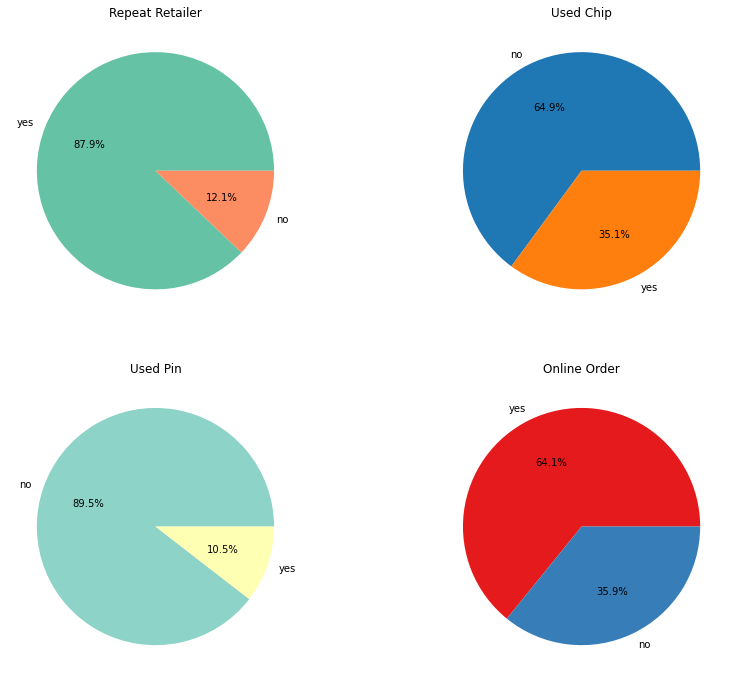

In [7]:
cols=['repeat_retailer', 'used_chip','used_pin_number', 'online_order']
palettes=['Set2', 'tab10', 'Set3', 'Set1']

f, axes=plt.subplots(2,2, figsize=(14,12))
for i,col in enumerate(cols):
    plt.subplot(2,2,i+1)
    plt.pie(df[col].value_counts() , 
           labels=df[col].value_counts().index,
           autopct='%.1f%%', 
           colors=sns.color_palette(palettes[i]))
    plt.title(col.split('_')[0].capitalize()+' '+col.split('_')[1].capitalize())
plt.show()

Let us now see the distribution of the three continuous numerical variables:

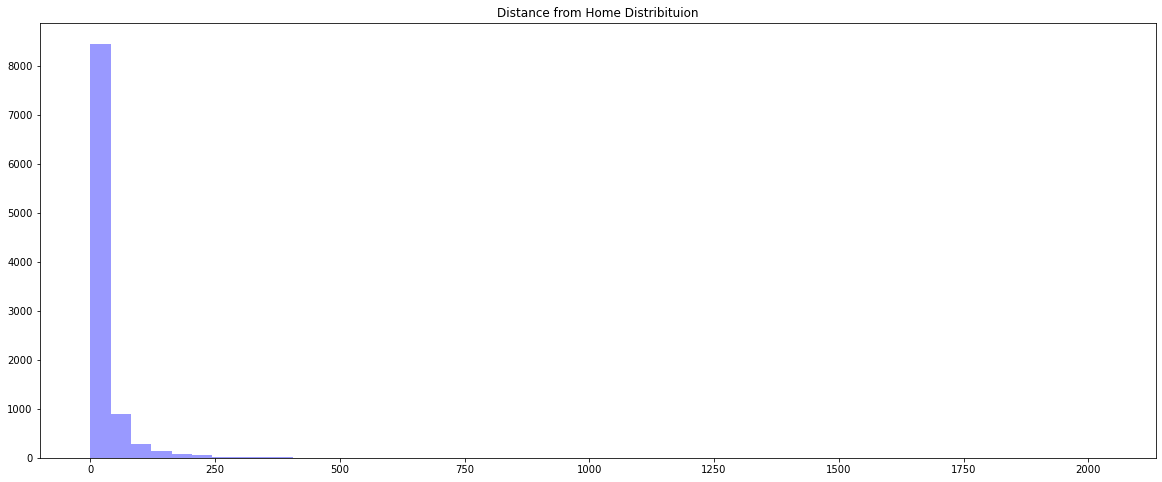

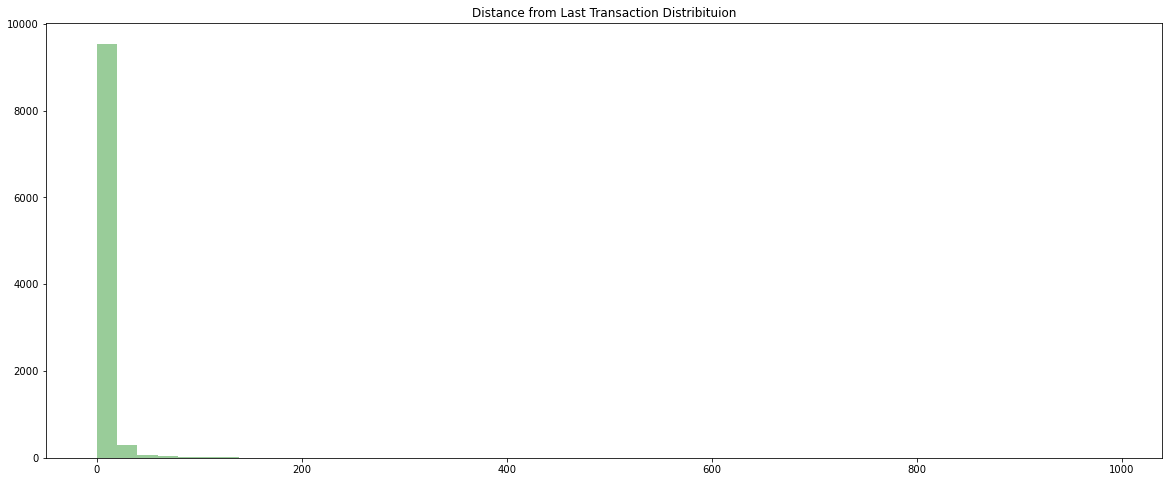

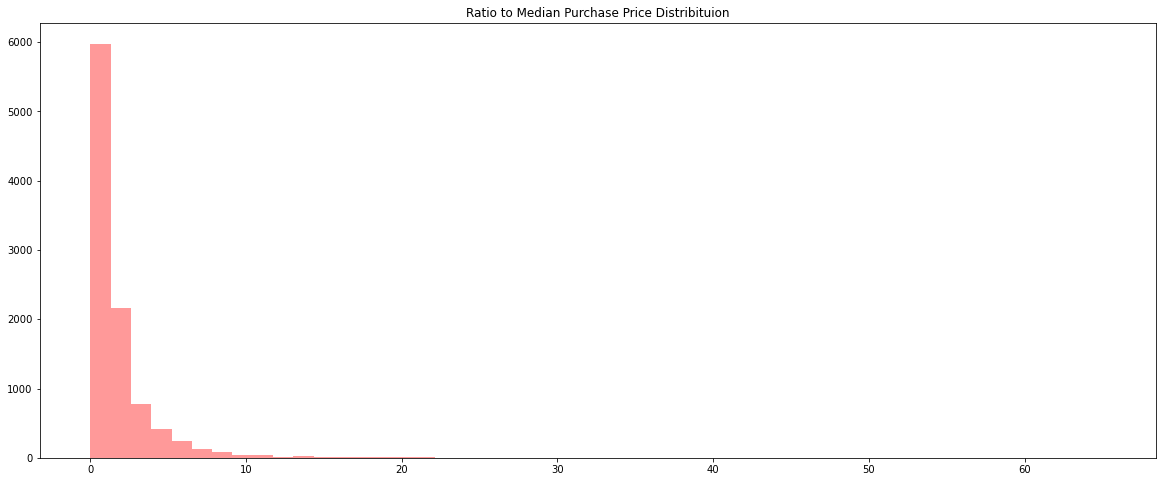

In [8]:
cols=['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
plt.figure(figsize=(20,8))
sns.distplot(x=df[cols[0]], kde=False, color='blue')
plt.title('Distance from Home Distribituion');

plt.figure(figsize=(20,8))
sns.distplot(x=df[cols[1]], kde=False, color='green')
plt.title('Distance from Last Transaction Distribituion');

plt.figure(figsize=(20,8))
sns.distplot(x=df[cols[2]], kde=False, color='red')
plt.title('Ratio to Median Purchase Price Distribituion');

Lastly, let us see how the avarage value of the continuous numerical variables, which have a positive linear correlation with the label 'fraud' according to the correlation matrix analysis, changes if the transaction is fraudulent or not:

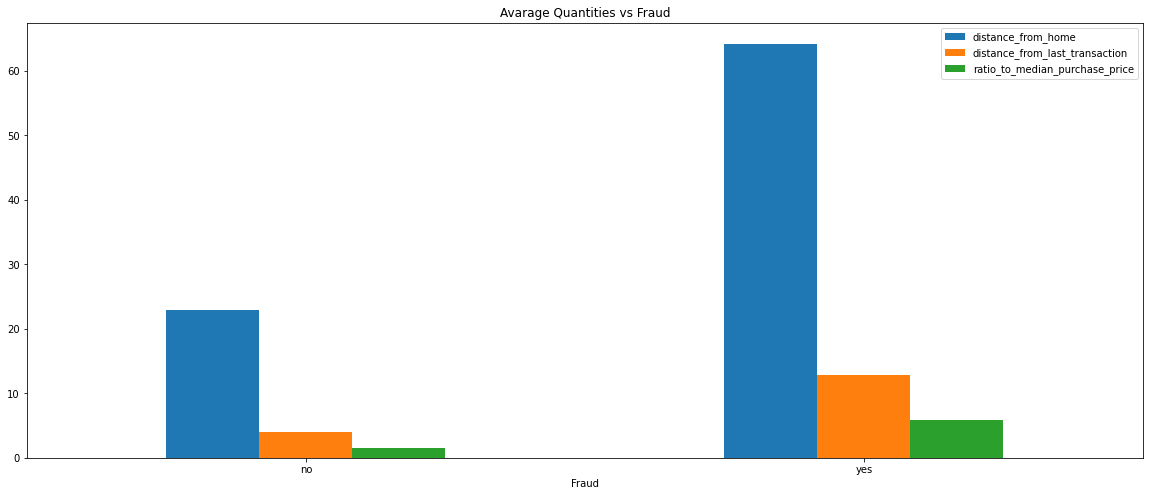

In [9]:
df.groupby('fraud')[cols].mean().plot(kind='bar', title='Avarage Quantities vs Fraud',
                   xlabel='Fraud', figsize=(20,8), rot=0);

### From this single plot it follows that the mean value of all these variables increases if the transaction is fraudulent, as we might expect from the correlation matrix analysis. 

# ML models

Let us now train some machine learning models in order to classify a credit card transaction. We start by reconverting the binary values into 0 and 1 values:

In [10]:
# I reconvert the values  
D= {'repeat_retailer':{'no':0, 'yes':1}, 'used_chip':{'no':0, 'yes':1},
       'used_pin_number':{'no':0, 'yes':1}, 'online_order':{'no':0, 'yes':1}}

for column in list(D.keys()):
    df[column] = df[column].map(D[column])

Now let us create the dataset with the features (X) and the labels (y):

In [11]:
X=scaler().fit_transform(df.drop('fraud', axis=1)) # features
y=df['fraud'].values  # labels 

In [12]:
print(X.shape, y.shape)

(10000, 7) (10000,)


Now we split the dataset into the training and the test set thanks to train_test_split:

In [13]:
# training-test splitting 
SEED=1
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=SEED)

Then we define two dictionaries 'models' and 'parameters', which contain the models and their hyperparameters that have to be tuned respectively.

In [14]:
models={'KNN': KNN(), 
        'DT': DT(), 
        'SVC': SVC(), 
        'RF': RF(random_state=SEED)}

parameters={'KNN':{'n_neighbors':[i for i in range(3,50)]}, 
           'DT':{'max_depth':[i for i in range(1,30)]}, 
           'SVC':{'kernel':['linear', 'poly',' rbf'], 'C':[i for i in range(101)],
                  'tol':[0.0001, 0.001, 0.01, 0.1], 'gamma':['scale','auto']},
           'RF':{'n_estimators':[i for i in range(10,100)],  
                'max_depth':[i for i in range(1,30)], 'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}}

Now we are ready for the **cross validation** procedure:

In [15]:
# cross validation 
cval={}
for model in models.keys():
    cval[model]=RSCV(models[model], parameters[model], cv=10, scoring='accuracy')
    cval[model].fit(X_train, y_train)
    print('The best parameters for '+model+' are: {}'.format(cval[model].best_params_))

The best parameters for KNN are: {'n_neighbors': 8}
The best parameters for DT are: {'max_depth': 18}
The best parameters for SVC are: {'tol': 0.0001, 'kernel': 'linear', 'gamma': 'auto', 'C': 83}
The best parameters for RF are: {'n_estimators': 94, 'max_features': 0.3, 'max_depth': 25}


After that, we can redefine the models dictionary by replacing the values with the **best models** according to the cross validation.

In [16]:
# I redefine the models dictionary by introducing the 'best models' according to the cross validation

models['KNN']=cval['KNN'].best_estimator_

models['DT']=cval['DT'].best_estimator_

models['SVC']=cval['SVC'].best_estimator_

models['RF']=cval['RF'].best_estimator_

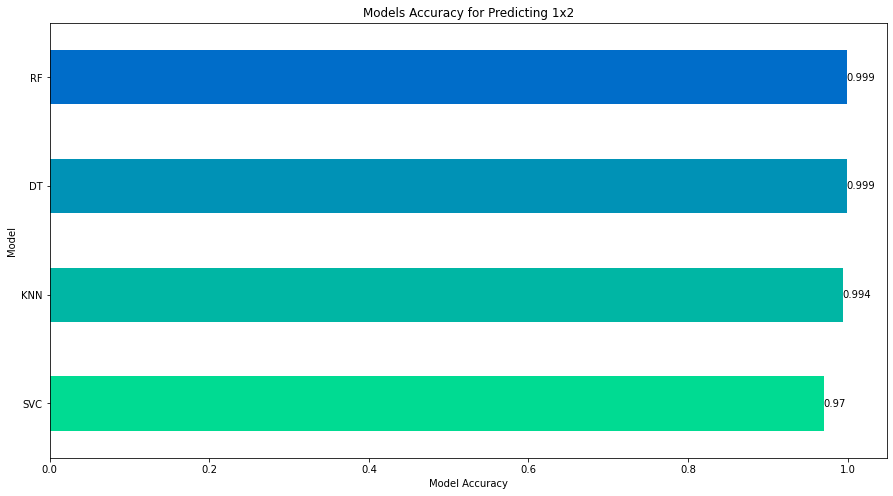

In [19]:
y_pred, accuracy={},{}

for model in models.keys():
    y_pred[model]=models[model].predict(X_test)
    accuracy[model]=round(accuracy_score(y_test, y_pred[model]),3)
 
plt.figure(figsize=(15,8))
ax=pd.Series(accuracy).sort_values().plot(kind='barh', title='Models Accuracy for Predicting 1x2',
                      color=sns.color_palette('winter_r'))

for container in ax.containers:
    ax.bar_label(container)  
    
plt.xlabel('Model Accuracy')
plt.ylabel('Model')
plt.show()

### Thus, the models with the best accuracy, almost 100%,  are RF and DT. However, as we previously said, in this case the accuracy is not the best metric for evaluating the performace of a model, because there is a strong imbalance between the two classes. Hence, we consider the specificity and the sensitivity of the models thanks to the classification_report:

In [20]:
report={}
for model in models.keys():
    report[model]=pd.DataFrame(classification_report(y_test, y_pred[model], output_dict=True)).transpose()

report['RF']

,precision,recall,f1-score,support
no,0.998916,1.000000,0.999458,1843.000
yes,1.000000,0.987261,0.993590,157.000
accuracy,0.999000,0.999000,0.999000,0.999
macro avg,0.999458,0.993631,0.996524,2000.000
weighted avg,0.999001,0.999000,0.998997,2000.000


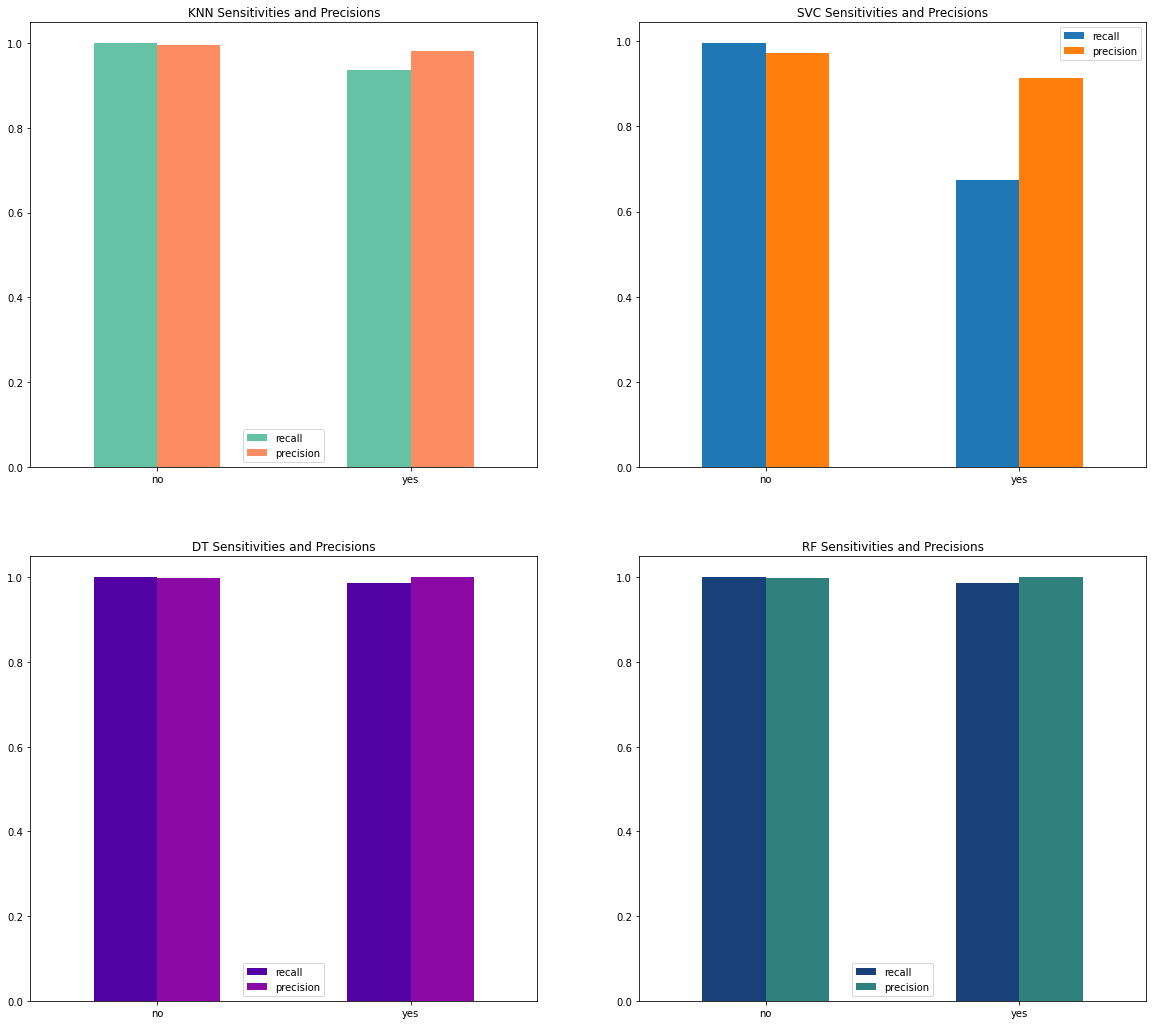

In [21]:
palettes=['Set2', 'tab10', 'plasma', 'gist_earth']

f, axes=plt.subplots(2,2,figsize=(20,18))

for i,model in enumerate(['KNN', 'SVC', 'DT', 'RF']):
    report[model][['recall', 'precision']].iloc[0:2].plot(kind='bar', title=model+' Sensitivities and Precisions', 
           rot=0, color=sns.color_palette(palettes[i]), ax=axes[i//2, i%2]);

### Let us remember that for the binary classification problems the recall of the 'True' ( or 'yes' in this case) class is the sensitivity of the model, while the recall of the 'False' ( or 'no' in this case) class is the specificity. Therefore, the best models are Random Forest and Decision Tree, because they have the higher and the most balanced values of sensitivity and specificity. Moreover, it is very difficult to choose between them, because they have essentially the same performace on the test set. Lastly, the worst model is SVC, since it has the unbalanced values of sensibility and specificity.

In order to conclude the analysis we use the Random Forest feature_importances method for evaluating the most important variables for the RF model. 

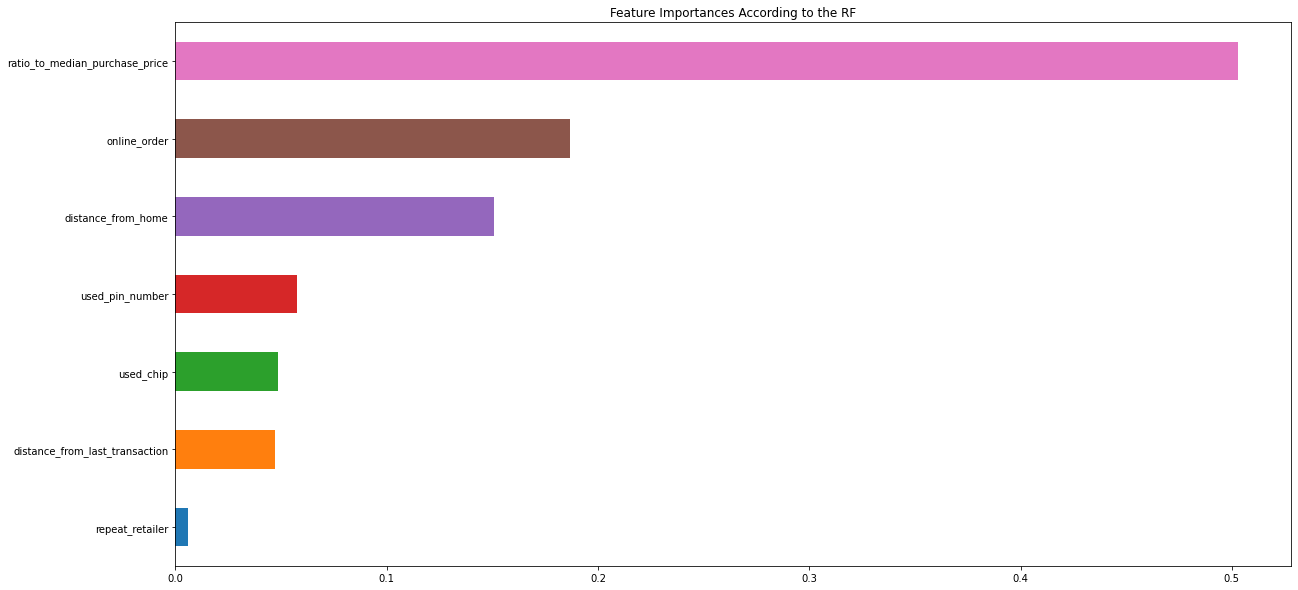

In [22]:
importances=pd.Series({df.columns[i]: models['RF'].feature_importances_[i] for i in range(df.shape[1]-1)})

plt.figure(figsize=(20,10))
importances.sort_values().plot(kind='barh', color=sns.color_palette('tab10'), title='Feature Importances According to the RF');

### In conclusion, the Random Forest consider as the most important features:  'ratio_to_median_purchase_price', 'online_order' and 'distance_from_home'. This is in complete agreement with the correlation matrix analysis, that indicates the same variables as the most relevant ones. 

# Conclusions

### In conclusion:

### 1) The best models to predict if a credit card transaction in fraudulent or not are Random Forest (RF) and Decision Tree (DT), since both have an accuracy of 99.9% and, more importantly, values of sensitivity and specificity nearly to 100%.

### 2) Choosing between them based on their performance is very hard, since the latter are essentially the same. 

### 3) The Random Forest indicates that the most important features for predicting if a transaction is fraudulent or not are: 'ratio_to_median_purchase_price', 'online_order' and 'distance_from_home'. This is in complete agreement with the EDA, and in particular with the correlation matrix analysis, indicates the same variables as the most relevant ones.